In [93]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import math
import torch
import torch_geometric
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected
import matplotlib.pyplot as plt

import e3nn
from functools import partial
import itertools

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from experiments.utils.plot_utils import plot_2d, plot_3d
from experiments.utils.train_utils import run_experiment_reg
from models import SchNetModel, DimeNetPPModel, SphereNetModel, EGNNModel, GVPGNNModel, TFNModel, MACEModel

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version 1.12.1+cu113
PyG version 2.3.1
e3nn version 0.5.1
Using device: cuda


In [196]:
def create_paired_star_graphs(num=5, fold=[5,], dim=3, n_pairs=2, seed=0):
    """Generate star graphs where spokes have random angles; certain nodes are paired up to be used for angle calculation.
    
    ----------
    Parameters:
    - num (int): number of star graphs to generate
    - fold (list of int): number of spokes to be considered when generating star graphs
    - dim (int): range of random angles (2D or 3D)
    - n_pairs (int): number of distinct pairs of nodes to be used in angle calculation
    - seed (int): random seed
    """

    assert dim == 2 or dim == 3, "dimension must be 2 or 3."
    assert n_pairs * 2 <= min(fold), "minimum fold must be >= two times the number of pairs."

    torch.manual_seed(seed)
    random.seed(seed)

    dataset = []

    for _ in range(num):
        n_spoke = random.choice(fold)
        # atoms representing central and non-central nodes
        pair_labels = []
        for i in range(n_pairs):
            pair_labels += [i+1,] * 2
        # the center (1st node) has lable 0, each pair has a unique number, and the rest has another
        atoms = torch.LongTensor( [0,] + pair_labels + [n_pairs+1,] * (n_spoke - 2*n_pairs))

        # edges read vertically; star graph: 0 -> 1, 0 -> 2 ...
        edge_index = torch.LongTensor( [ [0,] * n_spoke, list(range(1, n_spoke + 1)) ] )

        # fix the center
        pos = [torch.Tensor([0, 0, 0])]  

        if dim == 2:
            for _ in range(n_spoke):
                # random angle between 0 and 2*pi
                random_angle = random.uniform(0, 2 * math.pi)
                new_point = torch.Tensor([math.cos(random_angle), math.sin(random_angle), 0])
                pos.append(new_point)

        elif dim == 3:
            for _ in range(n_spoke):
                theta = random.uniform(0, 2 * math.pi)  # Random angle around z-axis
                phi = random.uniform(0, math.pi)  # Random angle from z-axis (polar angle)
                new_point = torch.Tensor([
                    math.sin(phi) * math.cos(theta),
                    math.sin(phi) * math.sin(theta),
                    math.cos(phi)
                ])
                pos.append(new_point)

        # scale pos to increase variance of angles
        # avg_vec = sum(pos)
        # alpha = random.uniform(-1, 2)
        # pos1 = [p + alpha * avg_vec for p in pos[1:]]
        # pos = pos[:1] + [v / torch.norm(v, p=2) for v in pos1] 
        
        # compute angles between paired nodes and the origin
        target_angles = []
        spoke_positions = pos[1:(2*n_pairs + 1)]
        for j in range(n_pairs):
            v1, v2 = spoke_positions[2*j], spoke_positions[2*j+1]
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            target_angles.append(angle)

        y = torch.Tensor(target_angles)
        
        pos = torch.stack(pos)
        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
        data.edge_index = to_undirected(data.edge_index)
        dataset.append(data)

    return dataset

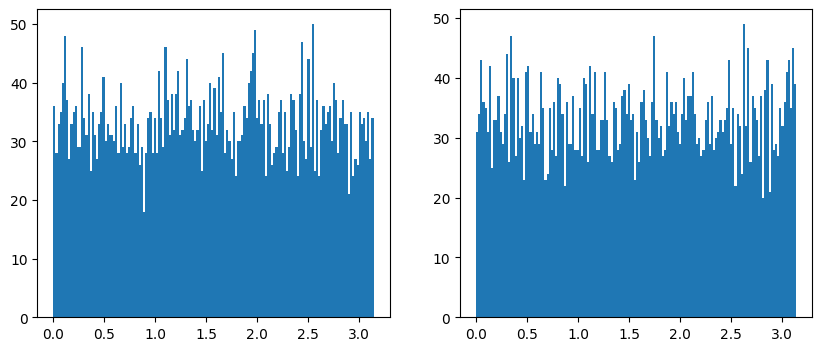

In [197]:
dataset = create_paired_star_graphs(num=5000, fold=[7,], dim=2, n_pairs=2)

angle1 = []
angle2 = []

for data in dataset:
    angle1.append(data.y[0])
    angle2.append(data.y[1])
    
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(angle1, bins=150)
plt.subplot(1,2,2)
plt.hist(angle2, bins=150)
plt.show()

In [212]:
def create_paired_star_graphs_with_two_centers(num=5, fold=[5,], dim=3, n_pairs=2, single_center=False, seed=0):
    """Generate star graphs where spokes have random angles; certain nodes are paired to be used for angle calculation.
    There are two centers (connected to every other node) and angles are computed with respect to both centers.
    
    ----------
    Parameters:
    - num (int): number of star graphs to generate
    - fold (list of int): number of spokes to be considered when generating star graphs
    - dim (int): range of random angles (2D or 3D)
    - n_pairs (int): number of distinct pairs of nodes to be used in angle calculation
    - single_center (Bool): whether or not to use angles wrt the first center only
    - seed (int): random seed
    """

    assert dim == 2 or dim == 3, "dimension must be 2 or 3."
    assert n_pairs * 2 <= min(fold), "minimum fold must be >= two times the number of pairs."

    torch.manual_seed(seed)
    random.seed(seed)

    dataset = []

    for _ in range(num):
        n_spoke = random.choice(fold)
        # atoms representing central and non-central nodes
        pair_labels = []
        for i in range(n_pairs):
            pair_labels += [i+1,] * 2
        # the two centers have label 0, one at the front and the other at the back; each pair has a unique number, and the rest has another
        atoms = torch.LongTensor( [0,] + pair_labels + [n_pairs+1,] * (n_spoke - 2*n_pairs) + [0,])  # (n_spoke + 2)

        # the two centers are connected with every other node
        edges1 = [0,] * n_spoke + [n_spoke + 1,] * n_spoke
        edges2 = list(range(1, n_spoke + 1)) * 2
        edge_index = torch.LongTensor( [ edges1, edges2 ] )

        pos = []  

        # generate the rest of the nodes, including the second center
        if dim == 2:
            for _ in range(n_spoke+2):
                # random angle between 0 and 2*pi
                random_angle = random.uniform(0, 2 * math.pi)
                new_point = torch.Tensor([math.cos(random_angle), math.sin(random_angle), 0])
                pos.append(new_point)

        elif dim == 3:
            for _ in range(n_spoke+2):
                theta = random.uniform(0, 2 * math.pi)  # Random angle around z-axis
                phi = random.uniform(0, math.pi)  # Random angle from z-axis (polar angle)
                new_point = torch.Tensor([
                    math.sin(phi) * math.cos(theta),
                    math.sin(phi) * math.sin(theta),
                    math.cos(phi)
                ])
                pos.append(new_point)

        # scale pos of spokes to increase variance of target angles
        # avg_vec = sum(pos)
        # alpha = random.uniform(-1, 2)
        # pos1 = [p + alpha * avg_vec for p in pos[1:-1]]
        # pos = pos[:1] + [v / torch.norm(v, p=2) for v in pos1] + pos[-1:]
        
        # compute angles between paired nodes and the first center
        target_angles1 = []
        spoke_positions = pos[1:(2*n_pairs + 1)]
        for j in range(n_pairs):
            v1, v2 = spoke_positions[2*j] - pos[0], spoke_positions[2*j+1] - pos[0]
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            target_angles1.append(angle)

        # compute angles between paired nodes and the second center
        target_angles2 = []
        spoke_positions = pos[1:(2*n_pairs + 1)]
        for j in range(n_pairs):
            v1, v2 = spoke_positions[2*j] - pos[-1], spoke_positions[2*j+1] - pos[-1]
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            target_angles2.append(angle)

        if single_center:
            y = torch.Tensor(target_angles1)  # (n_pair)
        else:
            y = torch.Tensor(target_angles1 + target_angles2)  # (n_pair * 2)
        
        pos = torch.stack(pos)  # (n_spoke + 2, 3)
        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
        data.edge_index = to_undirected(data.edge_index)
        dataset.append(data)

    return dataset

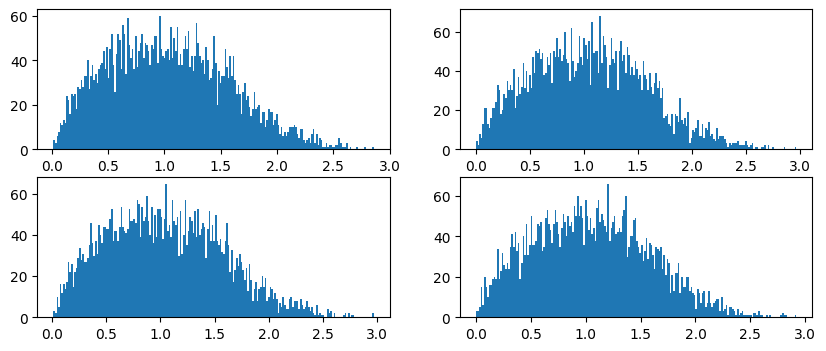

In [214]:
dataset = create_paired_star_graphs_with_two_centers(num=5000, fold=[7,], dim=3, n_pairs=2, seed=0)

angle1 = []
angle2 = []
angle3 = []
angle4 = []

for data in dataset:
    angle1.append(data.y[0])
    angle2.append(data.y[1])
    angle3.append(data.y[2])
    angle4.append(data.y[3])
    
plt.figure(figsize=(10, 4))
plt.subplot(2,2,1)
plt.hist(angle1, bins=200)
plt.subplot(2,2,2)
plt.hist(angle2, bins=200)
plt.subplot(2,2,3)
plt.hist(angle3, bins=200)
plt.subplot(2,2,4)
plt.hist(angle4, bins=200)
plt.show()

In [172]:
def create_star_graphs(num=5, fold=[3,], dim=3, target="max", seed=0):
    """Generate star graphs where spokes have random angles; target can be the max angle or the average angle.
    
    ----------
    Parameters:
    - num (int): number of star graphs to generate
    - fold (list of int): number of spokes to be considered when generating star graphs
    - dim (int): range of random angles (2D or 3D)
    - target (str): metric to be used in pooling angles
    - seed (int): random seed
    """

    assert dim == 2 or dim == 3, "dimension must be 2 or 3."
    assert target in ["max", "mean"], "regression target must be 'max' or 'mean' of angles"

    torch.manual_seed(seed)
    random.seed(seed)

    dataset = []

    for _ in range(num):
        n_spoke = random.choice(fold)
        # atoms representing central and non-central nodes; all nodes have label 0
        atoms = torch.LongTensor([0,] + [0,] * n_spoke)
        # edges read vertically; star graph: 0 -> 1, 0 -> 2 ...
        edge_index = torch.LongTensor( [ [0,] * n_spoke, list(range(1, n_spoke + 1)) ] )
        
        # fix the center
        pos = [torch.Tensor([0, 0, 0])]  

        if dim == 2:
            for _ in range(n_spoke):
                # random angle between 0 and 2*pi
                random_angle = random.uniform(0, 2 * math.pi)
                new_point = torch.Tensor([math.cos(random_angle), math.sin(random_angle), 0])
                pos.append(new_point)

        elif dim == 3:
            for _ in range(n_spoke):
                theta = random.uniform(0, 2 * math.pi)  # Random angle around z-axis
                phi = random.uniform(0, math.pi)  # Random angle from z-axis (polar angle)
                new_point = torch.Tensor([
                    math.sin(phi) * math.cos(theta),
                    math.sin(phi) * math.sin(theta),
                    math.cos(phi)
                ])
                pos.append(new_point)

        # scale pos to increase variance of max angles
        avg_vec = sum(pos)
        alpha = random.uniform(-1, 2)
        pos1 = [p + alpha * avg_vec for p in pos[1:]]
        pos = pos[:1] + [v / torch.norm(v, p=2) for v in pos1] 
        
        # compute all possible angles
        spoke_positions = pos[1:]
        angles = []
        for combo in itertools.combinations(spoke_positions, 2):
            v1, v2 = combo
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            angles.append(angle)
        
        if target == "max":
            y = torch.Tensor([ max(angles) ])
        elif target == "mean":
            y = torch.Tensor([ sum(angles)/len(angles) ])

        pos = torch.stack(pos)
        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
        data.edge_index = to_undirected(data.edge_index)
        dataset.append(data)

    return dataset

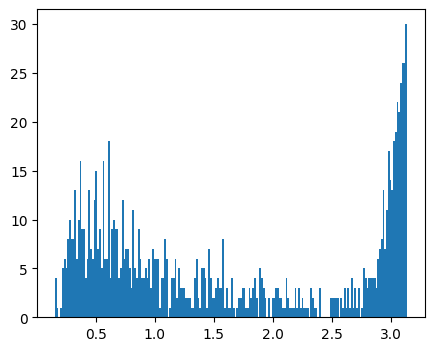

In [173]:
dataset = create_star_graphs(num=1000, fold=[7,], dim=2, target="max")

angle1 = []

for data in dataset:
    angle1.append(data.y[0])
    
plt.figure(figsize=(5, 4))
plt.hist(angle1, bins=200)
plt.show()

In [129]:
def create_paired_complete_graphs_with_full_centers(num=5, n_nodes=[6,], dim=3, n_pairs=2, seed=0):
    """Generate complete graphs where spokes have random angles; certain nodes are paired up to be used for angle calculation.
       Angles are calculated with respect to all nodes.
    
    ----------
    Parameters:
    - num (int): number of complete graphs to generate
    - n_nodes (list of int): number of nodes of the complete graph
    - dim (int): range of random angles (2D or 3D)
    - n_pairs (int): number of distinct pairs of nodes to be used in angle prediction
    - seed (int): random seed
    """

    assert dim == 2 or dim == 3, "dimension must be 2 or 3."
    assert n_pairs * 2 + 1 <= min(n_nodes), "minimum number of nodes must be >= two times the number of pairs + one center."

    torch.manual_seed(seed)
    random.seed(seed)

    dataset = []

    for _ in range(num):
        n_node = random.choice(n_nodes)
        pair_labels = []
        for i in range(n_pairs):
            pair_labels += [i+1,] * 2
        # each pair has a unique number and all other nodes have label 0
        atoms = torch.LongTensor( pair_labels + [0,] * (n_node - 2*n_pairs) )

        # edges read vertically; complete graph: 0 -> 1, 0 -> 2, ..., 1 -> 2, 1 -> 3, ...
        edge_index = torch.LongTensor([
            [i for i in range(n_node) for j in range(i + 1, n_node)],
            [j for i in range(n_node) for j in range(i + 1, n_node)]
        ])

        pos = []

        if dim == 2:
            for _ in range(n_node):
                # random angle between 0 and 2*pi
                random_angle = random.uniform(0, 2 * math.pi)
                new_point = torch.Tensor([math.cos(random_angle), math.sin(random_angle), 0])
                pos.append(new_point)

        elif dim == 3:
            for _ in range(n_node):
                theta = random.uniform(0, 2 * math.pi)  # Random angle around z-axis
                phi = random.uniform(0, math.pi)  # Random angle from z-axis (polar angle)
                new_point = torch.Tensor([
                    math.sin(phi) * math.cos(theta),
                    math.sin(phi) * math.sin(theta),
                    math.cos(phi)
                ])
                pos.append(new_point)

        # for each node, compute angles formed between specified node pairs using the current node as the center (may produce 0 if current node is in specified node pairs)
        y = []
        spoke_positions = pos[:(2*n_pairs)]
        for center in range(n_node):
            target_angles = []
            for j in range(n_pairs):
                v1, v2 = spoke_positions[2*j] - pos[center], spoke_positions[2*j+1] - pos[center]
                if torch.norm(v1) == 0 or torch.norm(v2) == 0:
                    angle = 0
                else:
                    angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
                target_angles.append(angle)
            y += target_angles
        y = torch.Tensor(y)
        
        pos = torch.stack(pos)
        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
        data.edge_index = to_undirected(data.edge_index)
        dataset.append(data)

    return dataset

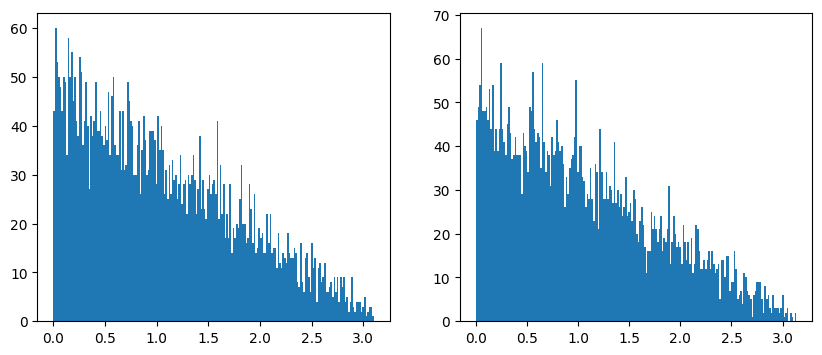

In [136]:
dataset = create_paired_complete_graphs_with_full_centers(num=5000, n_nodes=[7,], dim=2, n_pairs=2)

# for data in dataset[:3]:
#     plot_3d(data, lim=1)

angle1 = []
angle2 = []

for data in dataset:
    angle1.append(data.y[1])
    angle2.append(data.y[8])
    
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(angle1, bins=200)
plt.subplot(1,2,2)
plt.hist(angle2, bins=200)
plt.show()

In [218]:
tensor_2d = torch.tensor([[1, 2, 3],
                          [4, 5, 6],
                          [7, 8, 9]])

# Create a new tensor with the first and last rows
new_tensor = tensor_2d[[0, -1], 1]
print(new_tensor)

tensor([2, 8])
